In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import ipympl
import glob, os
import gym
import math
import random
from itertools import count
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from collections import namedtuple

In [2]:
from model import Actor, Critic, OrnsteinUhlenbeckActionNoise, NormalActionNoise, RandomActionNoise
from memory import ReplayDataset
from train import to_var, Optimizer_AC, Artificial_environment_noise_t, \
Artificial_environment_base_t, Artificial_environment_base_and_noise_t, Launcher_t, train, test

In [3]:
env = gym.make('MountainCarContinuous-v0')
print(env.action_space, env.action_space.high, env.action_space.low)
print(env.observation_space.shape[0], env.observation_space.high, env.observation_space.low)

Box(1,) [1.] [-1.]
2 [0.6  0.07] [-1.2  -0.07]


In [4]:
BATCH_SIZE = 32
GAMMA = 0.999
LRA=0.0001      #LEARNING RATE ACTOR
LRC=0.0001     #LEARNING RATE CRITIC
epsilon = 1
epsilon_decay = 1./1000000
noise_power = 3
noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1))
#noise = NormalActionNoise(np.zeros(1), 1)
print(noise_power*noise())
actor = Actor(env.observation_space.shape[0], 1)
critic = Critic(env.observation_space.shape[0], 1)

q_optimizer = optim.Adam(critic.parameters(), lr=LRC)
policy_optimizer= optim.Adam(actor.parameters(), lr=LRA)
#q_scheduler = StepLR(q_optimizer, step_size = 5, gamma = 0.1)

Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))
memory = ReplayDataset(10000, Transition)
loss_fn = nn.MSELoss().type(torch.FloatTensor)

optimizer = Optimizer_AC(actor, critic, q_optimizer, policy_optimizer, memory, loss_fn)
Artificial_environment_noise = Artificial_environment_noise_t(noise, env, noise_power)
Artificial_environment_base = Artificial_environment_base_t(actor, env)
Artificial_environment_base_and_noise = Artificial_environment_base_and_noise_t(actor, noise, env, 
                                        epsilon, epsilon_decay)

[0.04855959]


In [5]:
num_episodes = 100
Launcher = Launcher_t(Artificial_environment_noise, None, GAMMA, BATCH_SIZE)
history_rewards, success = test(Launcher, num_episodes)
print(success)

0.14


In [6]:
num_episodes = 100
Launcher = Launcher_t(Artificial_environment_base_and_noise, None, GAMMA, BATCH_SIZE)
history_rewards, success = test(Launcher, num_episodes)
print(success)

0.0


In [22]:
a = np.array([1, 2, 3])
a[-3:None]

array([1, 2, 3])

In [7]:
num_episodes = 100
Launcher = Launcher_t(Artificial_environment_noise, memory, GAMMA, BATCH_SIZE)
history_loss, history_rewards, success = train(Launcher, optimizer, num_episodes)

episode  0 : loss =  (4.246313849704082, 0.12418513827626439)  reward =  [-0.20000002]  discounted_reward =  [-3.680683898925781]  successes =  0  q =  -0.4906119282116381
episode  1 : loss =  (2.5937757415893374, 0.4553112008066349)  reward =  [-0.20000002]  discounted_reward =  [-3.680683898925781]  successes =  0  q =  -1.7406625751489269
episode  2 : loss =  (1.6086143053377773, 0.6251061692659335)  reward =  [-0.20000002]  discounted_reward =  [-3.680683898925781]  successes =  0  q =  -2.6894024690500085
episode  3 : loss =  (1.5634968072588575, 0.5828634557632589)  reward =  [-0.09518832]  discounted_reward =  [-0.33855879306793213]  successes =  1  q =  -3.189875000201094
episode  4 : loss =  (1.4857759013597445, 0.3854469605528125)  reward =  [-0.20000002]  discounted_reward =  [-3.680683898925781]  successes =  1  q =  -3.2715711578393516
episode  5 : loss =  (1.5215032415522052, 0.17140540072775742)  reward =  [-0.20000002]  discounted_reward =  [-3.680683898925781]  success

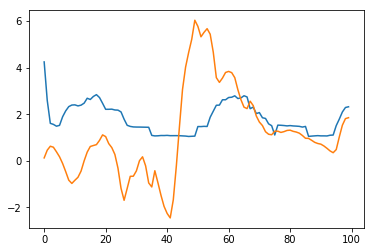

In [8]:
plt.plot(history_loss)

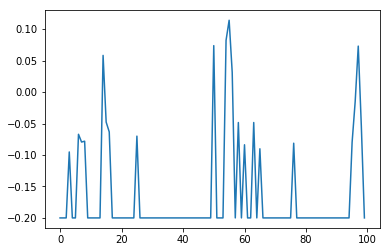

In [9]:
plt.plot(history_rewards)

In [10]:
print(success)

0.21


In [12]:
num_episodes = 100
Launcher = Launcher_t(Artificial_environment_base, None, GAMMA, BATCH_SIZE)
history_rewards, success = test(Launcher, num_episodes)
print(success)

0.0


In [13]:
num_episodes = 100
Launcher = Launcher_t(Artificial_environment_base_and_noise, memory, GAMMA, BATCH_SIZE)
history_loss, history_rewards, success = train(Launcher, optimizer, num_episodes)

episode  0 : loss =  (4660200.511182111, 4.202667664922972)  reward =  [-180.33684]  discounted_reward =  [-3328.825]  successes =  0  q =  -13.49621871485116
episode  1 : loss =  (4343995.634717785, 6.588139671106304)  reward =  [-104.460335]  discounted_reward =  [-1931.1451171875]  successes =  0  q =  -23.185759925232908
episode  2 : loss =  (3837658.2523961677, 8.186848529738487)  reward =  [-42.12807]  discounted_reward =  [-783.9046875]  successes =  0  q =  -30.642590330812496
episode  3 : loss =  (3363092.718317359, 9.478100883313274)  reward =  [-11.791528]  discounted_reward =  [-215.5924560546875]  successes =  0  q =  -37.079935518697425
episode  4 : loss =  (2904142.077209796, 10.498312772399446)  reward =  [-0.17376348]  discounted_reward =  [-3.1990127563476562]  successes =  0  q =  -42.613912381303194
episode  5 : loss =  (2459916.22630458, 11.01156133584702)  reward =  [-2.809096]  discounted_reward =  [-53.685491943359374]  successes =  0  q =  -46.48620144780071
ep